In [27]:
from csbdeep.models import Config, CARE
from metrics import metrics_psnr, metrics_ssim, metrics_lpips
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile

In [6]:
def collate_noisy_gt(noisy_paths, gt_paths):
    data = {X:Y for X, Y in zip(noisy_paths, gt_paths)}
    return data

def load_planaria_test_data():
    test_imgs_X1 = glob.glob('/storage/home/hcoda1/0/schaudhary9/p-hl94-0/siva_projects/CARE-dataset/Denoising_Planaria/test_data/condition_1/*.tif')
    test_imgs_X2 = glob.glob('/storage/home/hcoda1/0/schaudhary9/p-hl94-0/siva_projects/CARE-dataset/Denoising_Planaria/test_data/condition_2/*.tif')
    test_imgs_X3 = glob.glob('/storage/home/hcoda1/0/schaudhary9/p-hl94-0/siva_projects/CARE-dataset/Denoising_Planaria/test_data/condition_3/*.tif')
    test_imgs_Y = glob.glob('/storage/home/hcoda1/0/schaudhary9/p-hl94-0/siva_projects/CARE-dataset/Denoising_Planaria/test_data/GT/*.tif')
    data = {}
    data.update(collate_noisy_gt(test_imgs_X1, test_imgs_Y))
    data.update(collate_noisy_gt(test_imgs_X2, test_imgs_Y))
    data.update(collate_noisy_gt(test_imgs_X3, test_imgs_Y))
    return data

In [7]:
data = load_planaria_test_data()

axes = 'YX'
model_name = 'care_planaria_2D'
model_basedir = '/storage/home/hcoda1/0/schaudhary9/p-hl94-0/siva_projects/baseline_denoising/care'
model = CARE(config=None, name=model_name, basedir=model_basedir)

Loading network weights from 'weights_best.h5'.


1/1 [==============================] - 4s 4s/step


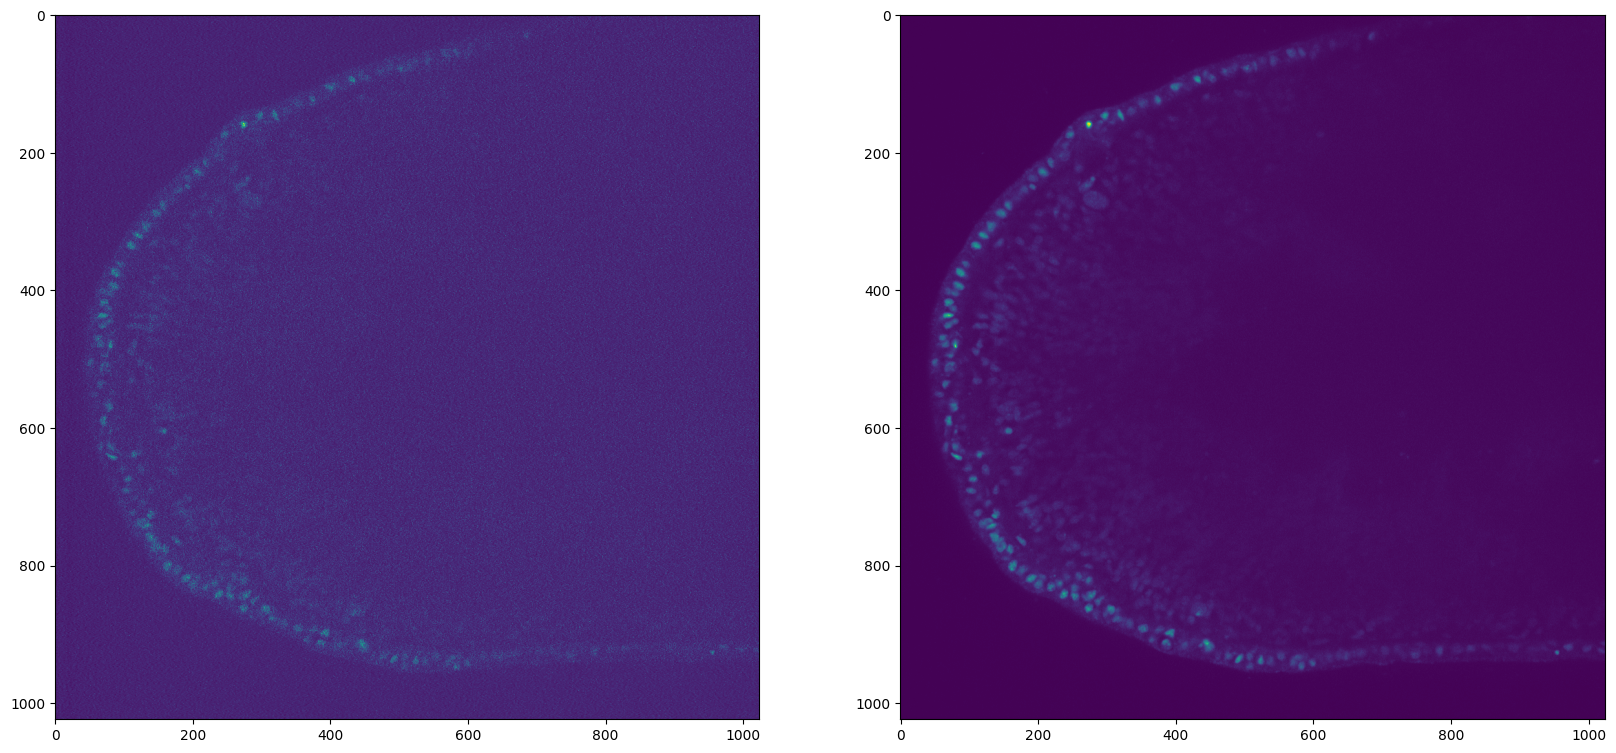

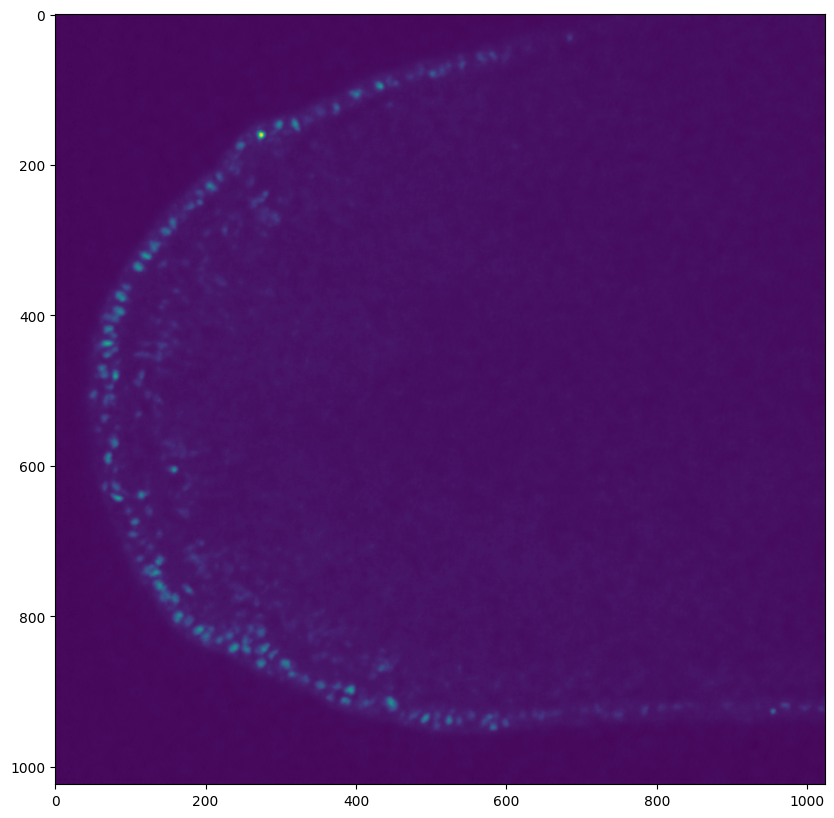

In [22]:
noisy_imgs = list(data.keys())
idx = 0
X = tifffile.imread(noisy_imgs[idx]).astype(np.float32)
Y = tifffile.imread(data[noisy_imgs[idx]]).astype(np.float32)

z = 0
restored = model.predict(X[z], axes)
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(X[z])
ax[1].imshow(Y[z])
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(restored)

In [9]:
import torch
from pytorch_fid_master.src.pytorch_fid.fid_score import calculate_frechet_distance, calculate_activation_statistics
from pytorch_fid_master.src.pytorch_fid.inception import InceptionV3

In [23]:
def metrics_fid(img1, img2):
    device = torch.device('cuda' if (torch.cuda.is_available()) else 'cpu')
    batch_size=50
    dims=2048
    num_workers=1
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
    model = InceptionV3([block_idx]).to(device).float()
    m1, s1 = calculate_activation_statistics([img1], model, batch_size=batch_size, dims=dims,
                                    device=device, num_workers=num_workers)
    m2, s2 = calculate_activation_statistics([img2], model, batch_size=batch_size, dims=dims,
                                    device=device, num_workers=num_workers)
    score = calculate_frechet_distance(m1, s1, m2, s2)
    return score

In [24]:
fid_score = metrics_fid(img1=restored, img2=Y[z])

100%|██████████| 1/1 [01:46<00:00, 106.74s/it]


100%|██████████| 1/1 [01:46<00:00, 106.68s/it]


In [25]:
fid_score

741783318.3216162

In [28]:
psnr_score = metrics_psnr(img1=restored, img2=Y[z], max_value=1)
ssim_score = metrics_ssim(img1=restored, img2=Y[z])
lpips_score = metrics_lpips(img1=restored, img2=Y[z])

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/storage/home/hcoda1/0/schaudhary9/p-hl94-0/.conda/envs/baseline_denoising/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/storage/home/hcoda1/0/schaudhary9/p-hl94-0/.conda/envs/baseline_denoising/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /storage/home/hcoda1/0/schaudhary9/p-hl94-0/.conda/envs/baseline_denoising/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth
